In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [2]:
### Import the Malaria dataset from TensorFlow
dataset, dataset_info = tfds.load("malaria", split = ['train[:70%]', 'train[70%:85%]', 'train[85%:]'], with_info = True, shuffle_files = True)

In [3]:
### Split the Dataset
training_dataset = dataset[0]
validation_dataset = dataset[1]
testing_dataset = dataset[2]

print(len(training_dataset), len(validation_dataset), len(testing_dataset))

19291 4133 4134


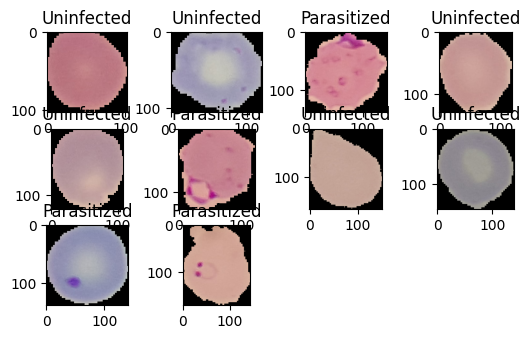

In [4]:
### Visualize the images and their labels

# Helper function to get the label
def get_label(sample_label):
  if sample_label == 1: 
    return "Uninfected"
  else:
    return "Parasitized"

for i, sample in enumerate(training_dataset.take(10)):
  plt.subplot(4,4,i+1)
  plt.imshow(sample['image'])
  plt.title(get_label(sample['label'].numpy()))

In [5]:
### Resize the images to make them all of unique sizes

def resize_rescale(inputs):
  return tf.image.resize(inputs['image'], (150,150))/255, inputs['label']

training_dataset = training_dataset.map(resize_rescale).shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch( 32 ).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(resize_rescale).shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch( 32 ).prefetch(tf.data.AUTOTUNE)
testing_dataset = testing_dataset.map(resize_rescale).shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch( 32 ).prefetch(tf.data.AUTOTUNE)

In [6]:
training_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [7]:
### LeNet Convolutional Architecture
from keras import Sequential
from keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization

ANN = Sequential([
  InputLayer( shape = (150, 150, 3) ),

  ## Fetaure Extraction
  # filter = 6 => 6 feature detectors, kernel_size = 3 => window of 3x3 
  Conv2D( filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu' ),
  MaxPool2D( pool_size = 2, strides = 2 ),
  BatchNormalization(),

  Conv2D( filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu' ),
  MaxPool2D( pool_size = 2, strides = 2 ),
  BatchNormalization(),

  Flatten(),

  ## Learning and Predicting
  Dense( units = 100, activation = "relu" ),
  BatchNormalization(),
  Dense( units = 10, activation = "relu" ),
  BatchNormalization(),
  Dense( units = 1, activation = "sigmoid" ),
])

ANN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 74, 74, 6)      │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 16)     │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 36, 36, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     2,073,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,076,297 (7.92 MB)

 Trainable params: 2,076,033 (7.92 MB)

 Non-trainable params: 264 (1.03 KB)

In [8]:
### Train the Model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy

ANN.compile( optimizer = Adam(), loss = BinaryCrossentropy(), metrics = [BinaryAccuracy()] )

ANN.fit( training_dataset, validation_data = validation_dataset, epochs = 5, verbose = 1 )

Epoch 1/5


603/603 ━━━━━━━━━━━━━━━━━━━━ 61s 96ms/step - binary_accuracy: 0.7706 - loss: 0.4848 - val_binary_accuracy: 0.7094 - val_loss: 0.7144
Epoch 2/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 61s 101ms/step - binary_accuracy: 0.9316 - loss: 0.1957 - val_binary_accuracy: 0.9412 - val_loss: 0.1780
Epoch 3/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 58s 96ms/step - binary_accuracy: 0.9462 - loss: 0.1540 - val_binary_accuracy: 0.9465 - val_loss: 0.1484
Epoch 4/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 60s 100ms/step - binary_accuracy: 0.9634 - loss: 0.1094 - val_binary_accuracy: 0.9453 - val_loss: 0.1679
Epoch 5/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 61s 101ms/step - binary_accuracy: 0.9724 - loss: 0.0822 - val_binary_accuracy: 0.9061 - val_loss: 0.2528


In [9]:
ANN.evaluate(testing_dataset)

130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - binary_accuracy: 0.9133 - loss: 0.2580


[0.25815314054489136, 0.9095306992530823]